# GDP understanding using Linear Regression Models
## Part 2: Linear Regression Model

In the previous notebook. We analyze the Gapminder dataset looking for the best indicators that could affect Gross Domestic Product (GDP) in  country. Also we clean the dataset, removing duplicated values and ignoring indicators with missing values.

## 1. Loading the data

In [1]:
# Packages needed
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import numpy as np
import scipy.stats as stats
# Styles for Matplotlib
plt.style.use('dark_background')

In [2]:
# Pandas configuration for extending the number of columns and rows to show
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [3]:
# Loading gapmander CSV final file (After cleansed) 
df = pd.read_csv("./data/gapminder_final.csv")

## 2. Selecting features to train the model

After some analysis in the previous notebook we are going to select the next features. These features doesn't have Null values and tend to have a linear behaviour versus incomeperperson.

In [4]:
features = [
    'continent',
    'internetuserate',
    'urbanrate',
    'lifeexpectancy',
    'employrate',
    'alcconsumption',
    'breastcancerper100th',
    'suicideper100th',
] 
df[["country"] + features].sample(5)

,country,continent,internetuserate,urbanrate,lifeexpectancy,employrate,alcconsumption,breastcancerper100th,suicideper100th
79,Botswana,Africa,5.999836,59.58,53.183,46.000000,6.97,33.4,11.213970
19,Cuba,North America,15.899970,75.66,79.143,56.000000,5.12,31.2,10.571910
114,Bahrain,Asia,54.992809,88.52,75.057,60.400002,4.19,40.2,4.414990
44,Moldova,Europe,40.122235,41.76,69.317,44.299999,23.01,49.6,15.538490
58,Ethiopia,Africa,0.749996,17.00,59.274,80.699997,4.10,24.7,10.071942


All features are numeric, except Continent, to fix this we are going to assign one value numeric based on the average of GDP in that continent.

In [5]:
df["continent"].unique()

array(['Europe', 'North America', 'Africa', 'Asia', 'South America',
       'Oceania'], dtype=object)

Text(0.5, 1.0, 'Average GDP per Continent')

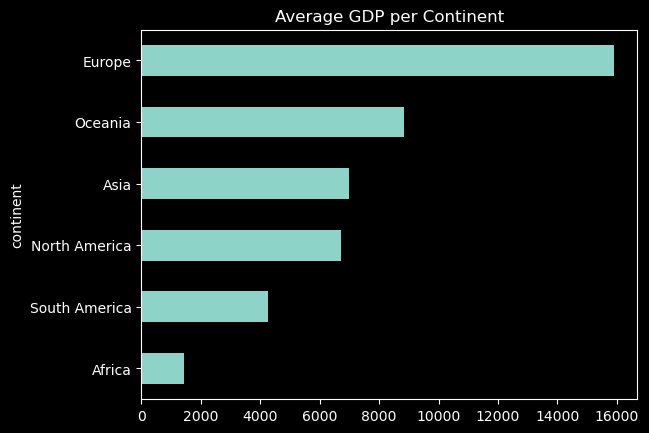

In [6]:
df.groupby("continent")['incomeperperson'].mean().sort_values().plot.barh()
plt.title("Average GDP per Continent")

In [7]:
continent_to_numeric = {
    "Europe": 6,
    "Oceania": 5,
    "Asia": 4,
    "North America": 3,
    "South America": 2,
    "Africa": 1
}

# New column with continent numeric
df['continent_numeric'] = df['continent'].replace(continent_to_numeric)

df[["country", "continent", "continent_numeric"]].sample(5)

,country,continent,continent_numeric
88,Portugal,Europe,6
19,Cuba,North America,3
66,Rwanda,Africa,1
81,Madagascar,Africa,1
131,Qatar,Asia,4


In [8]:
# Adding this new column to features
features.remove('continent')
features.append('continent_numeric')

Finally, in the univariate analysis we detected some outliers with the biggest GDP values. We are going to exclude them for our model.

In [9]:
# Filtering DF with no outliers
q1 = df["incomeperperson"].quantile(0.25)
q3 = df["incomeperperson"].quantile(0.75)
iqr = q3 - q1
outliers_max_factor = 1.5
no_outliers_df = df[df["incomeperperson"] <= (q3 + outliers_max_factor * iqr)]

## 4. Splitting train and test datasets

In [10]:
# Saving X and Y
X = no_outliers_df[features]
Y = no_outliers_df["incomeperperson"]

In [11]:
# 20% for test y 80% for train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [12]:
print("Train", X_train.shape)
print("Test", X_test.shape)

Train (100, 8)
Test (26, 8)


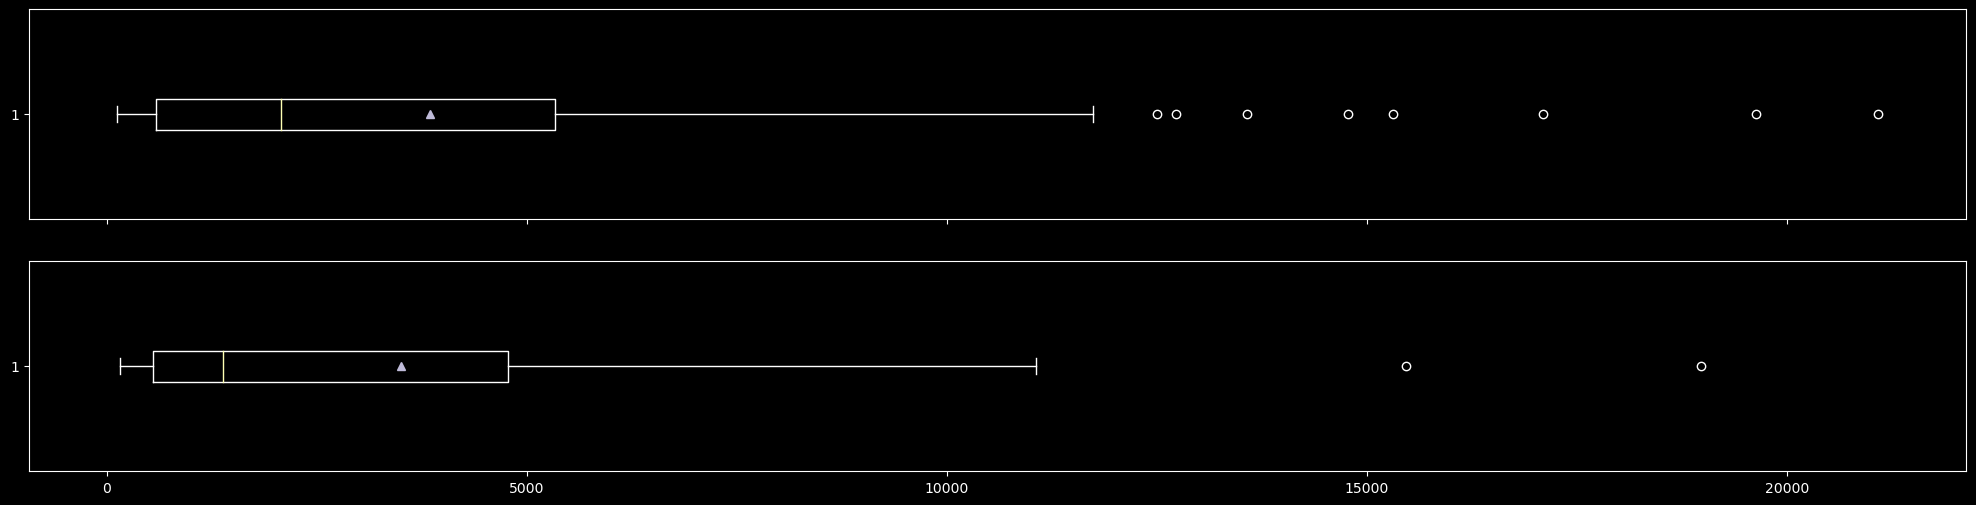

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(25, 6))
ax1.boxplot(Y_train, showmeans=True, vert=False)
ax2.boxplot(Y_test, showmeans=True, vert=False)
plt.show()

## 5. First Model

For this model we are going to use a Pipeline with an StandardScaler and a LinearRegression. 

### 5.1 Training

In [14]:
# Using Pipeline to Scalling variables
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)
pipeline

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [15]:
pipeline.fit(X_train, Y_train)
model = pipeline["model"]

In [16]:
print("Coeficients:", model.coef_)
print("Intercept:", model.intercept_)

Coeficients: [ 2943.74582003  1560.89815777  -584.1767123   1159.77417327
 -1085.59746913   790.94267493  -393.80027387   107.73216596]
Intercept: 3847.8500472980018


In [17]:
# Showing Coeficients
coefficients_df = pd.DataFrame({"feature": features, "coef": pipeline["model"].coef_})
coefficients_df

,feature,coef
0,internetuserate,2943.745820
1,urbanrate,1560.898158
2,lifeexpectancy,-584.176712
3,employrate,1159.774173
4,alcconsumption,-1085.597469
5,breastcancerper100th,790.942675
6,suicideper100th,-393.800274
7,continent_numeric,107.732166


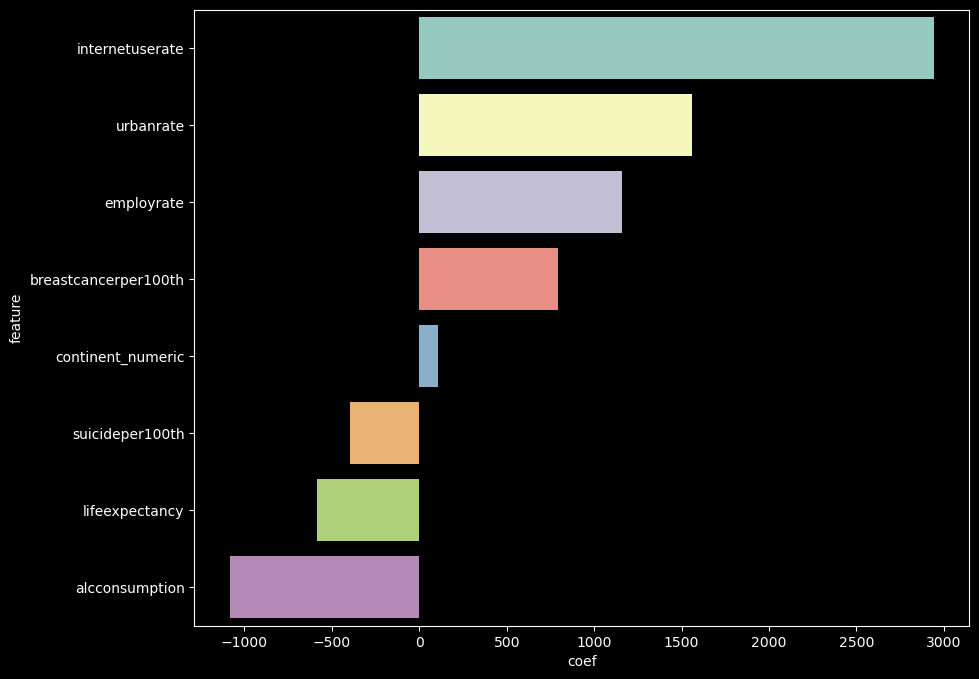

In [18]:
# Char tof coefficients
plt.figure(figsize=(10, 8))
sns.barplot(
    y=coefficients_df["feature"],
    x=coefficients_df["coef"],
    orient="h",
    order=coefficients_df.sort_values('coef', ascending = False).feature
)
plt.show()

Internetuserate and Urbanrate are one of the most import indicators that affects the GDP. Also we can notice the number of suicides and alcohol consumption negative affects the GDP.

### 5.2 Evaluating Model

In [19]:
preds_train = pipeline.predict(X_train)
preds_test = pipeline.predict(X_test)

In [20]:
print("MAE train:", mean_absolute_error(Y_train, preds_train))
print("MAE test:", mean_absolute_error(Y_test, preds_test))

MAE train: 2089.4144468578866
MAE test: 2491.711516643737


In [21]:
print("RMSE train:", np.sqrt(mean_squared_error(Y_train, preds_train)))
print("RMSE test:", np.sqrt(mean_squared_error(Y_test, preds_test)))

RMSE train: 2898.945788043602
RMSE test: 3372.859847930201


In [22]:
print("R2 score:", r2_score(Y_train, preds_train))

R2 score: 0.6022162760539372


This model is not the best in terms of predictions of it is ideal when we are trying to interpret which indicators affects the most the GDP

## 6. Validating Features

### 6.1. Collinearity

In order to develop a good lineal regression model we need to check if these 5 attributes doesn't have a correlation greater than 0.8.

In [23]:
corr = no_outliers_df[features + ["incomeperperson"]].corr()
corr

,internetuserate,urbanrate,lifeexpectancy,employrate,alcconsumption,breastcancerper100th,suicideper100th,continent_numeric,incomeperperson
internetuserate,1.000000,0.583731,0.695122,-0.308259,0.474684,0.687847,0.025597,0.602293,0.703321
urbanrate,0.583731,1.000000,0.583565,-0.423138,0.219072,0.488100,-0.211262,0.269228,0.562333
lifeexpectancy,0.695122,0.583565,1.000000,-0.359932,0.192179,0.558064,-0.106644,0.640335,0.557465
employrate,-0.308259,-0.423138,-0.359932,1.000000,-0.125213,-0.346424,0.025581,-0.337230,-0.155276
alcconsumption,0.474684,0.219072,0.192179,-0.125213,1.000000,0.474026,0.362652,0.433069,0.191143
breastcancerper100th,0.687847,0.488100,0.558064,-0.346424,0.474026,1.000000,0.018011,0.523598,0.566123
suicideper100th,0.025597,-0.211262,-0.106644,0.025581,0.362652,0.018011,1.000000,0.160565,-0.171413
continent_numeric,0.602293,0.269228,0.640335,-0.337230,0.433069,0.523598,0.160565,1.000000,0.365231
incomeperperson,0.703321,0.562333,0.557465,-0.155276,0.191143,0.566123,-0.171413,0.365231,1.000000


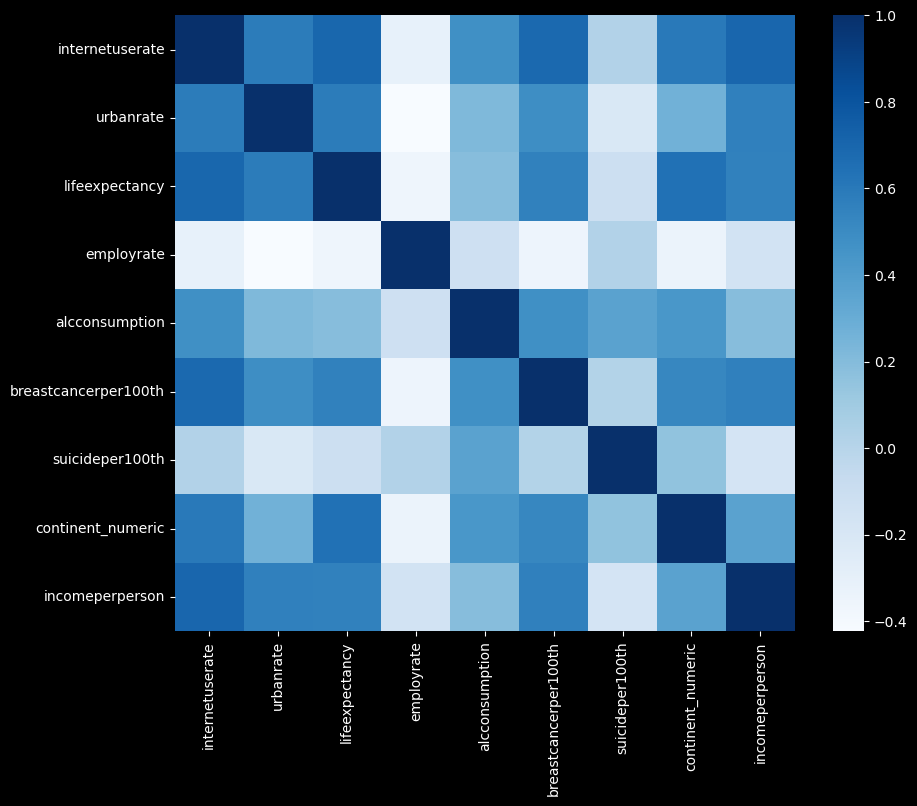

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="Blues")
plt.show()

Indicators selected are not greatly correlated between each other. This means these indicators could be good features in a lineal regression model.

### 6.2 Lineality

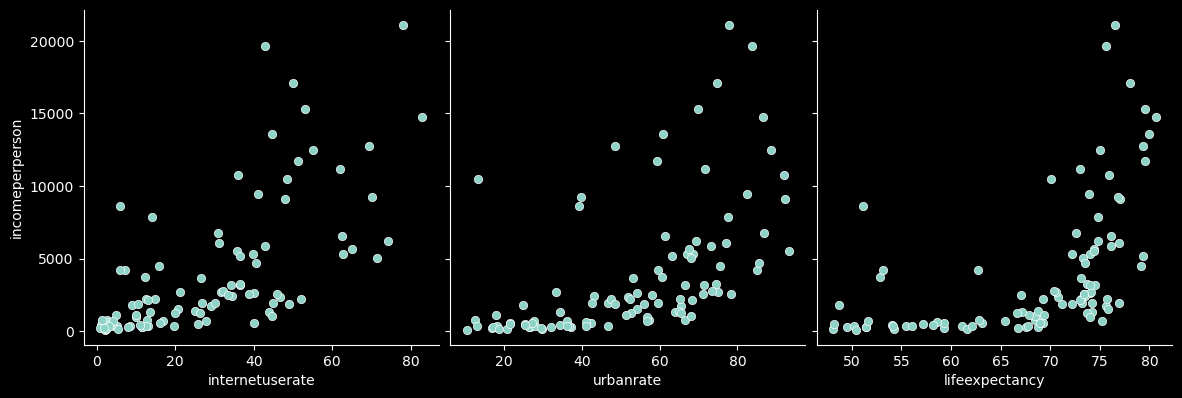

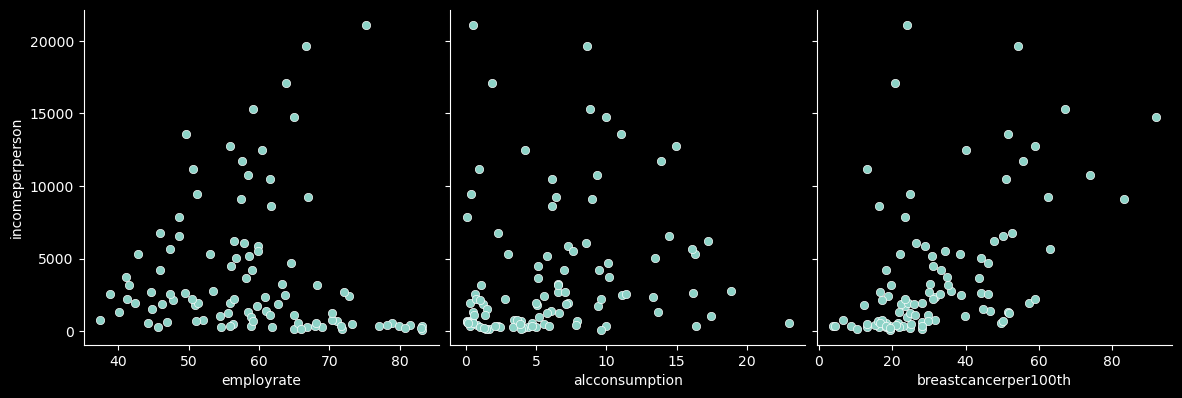

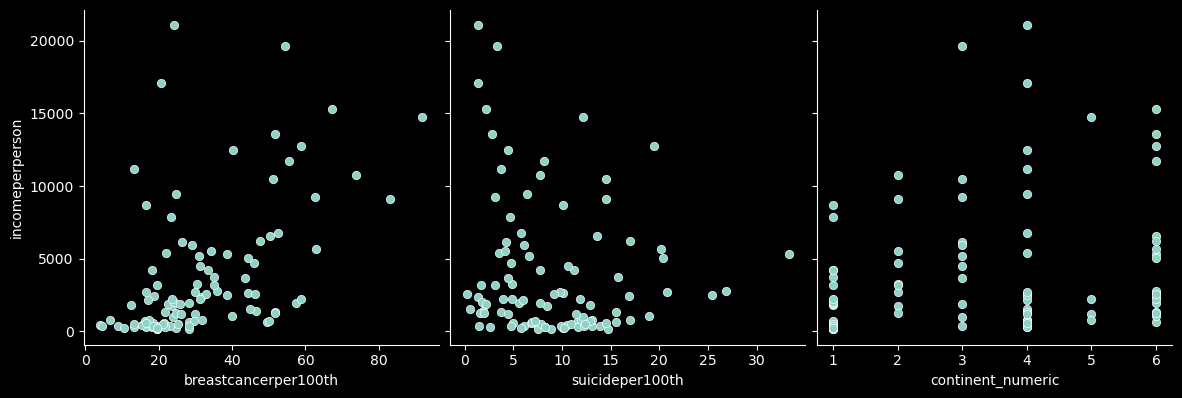

In [25]:
# Pairplot for each indicator
for indicators in [(0,3), (3,6), (5,9)]:
    sns.pairplot(
        pd.concat([X_train, Y_train], axis=1), height=4, y_vars="incomeperperson", 
        x_vars=features[indicators[0]:indicators[1]], kind="scatter")

Some indicators have linear behaviour. But the indicators in the first row (interenetuserate, urbanrate, lifeexpectancy) have a logarithmic behavior. This could explain why our first model doesn't have a good r squared value.

### 6.3 Normality in Errors

In [26]:
errors = (pipeline.predict(X_train[features])-Y_train).values
errors

array([ 2.59332741e+02,  1.75400189e+01,  3.26804650e+03, -7.73734656e+03,
        3.04372040e+01, -3.09254325e+03,  1.48118368e+03,  3.55313020e+03,
        1.38199821e+03,  4.13852660e+03, -1.74107585e+02, -1.35338359e+02,
        1.74613028e+03,  4.57055916e+03,  1.03374976e+03, -9.04520203e+02,
       -7.10751288e+02,  7.12931395e+02, -5.74265459e+03, -9.77536379e+01,
        3.20650225e+02,  9.26765294e+02, -1.82853251e+03,  3.07345909e+03,
        1.88772797e+03, -3.80399421e+02,  3.28263882e+03,  2.12817328e+03,
        8.77569946e+02,  1.84447828e+03,  1.19272051e+02, -5.30898381e+03,
       -5.83696270e+03,  2.21249375e+03,  1.49326097e+03, -4.57294854e+03,
        4.39579923e+03, -1.74813409e+03, -8.05045536e+03,  6.56671501e+02,
        1.87412537e+03,  1.89632951e+02, -3.52844491e+03,  1.71851354e+03,
       -2.65165154e+02, -1.42987000e+03,  2.44628189e+02, -5.52128666e+03,
        2.85384518e+03, -9.65098044e+02, -3.54912831e+03, -4.68824118e+02,
       -5.90975018e+03, -

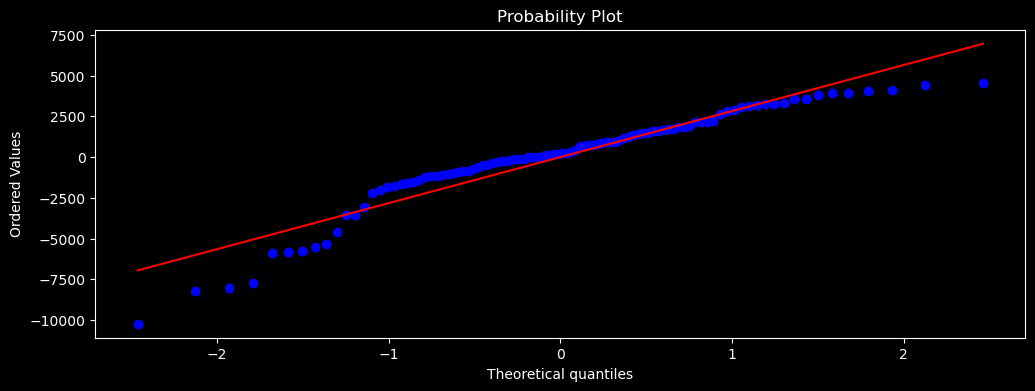

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(12, 4))

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes)

It tends to be a normal distribution, this could be explained because we remove outliers from the beginning

### 6.4 Constant variance (Homoscedasticity)

<Axes: >

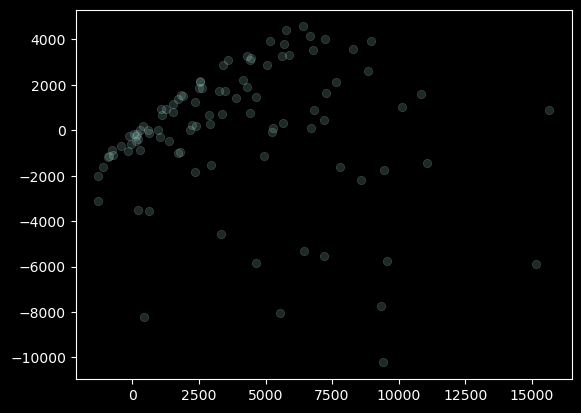

In [28]:
sns.scatterplot(x = pipeline.predict(X_train[features]), y=errors, alpha=0.2)

Apparently errors variance is not constant when the objective variable is changing. This could be solved applying non linear transformations.

##  7. Second Model

As we observed, the previous model doesn't give us really good predictions, this is because we assume all variables were linear. To solve this we are going to add a PolynomialFeature of degree 2 into our Pipeline to build a new Model. This model should have better predictions, but worst interpretability. 

### 7.1 Training

In [29]:
# Using Pipeline to Scalling variables
pipeline = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)
pipeline

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [30]:
pipeline.fit(X_train, Y_train)
model = pipeline["model"]

In [31]:
print("Coeficients:", model.coef_)
print("Intercept:", model.intercept_)

Coeficients: [-14977.09384482   1481.71504333  12007.24919362   5716.5475288
   2895.02507491 -16842.21510414  19182.70996019 -21555.144214
    521.49662349  -2844.68919565  19156.55749228    425.03360022
   -905.96985487  -5051.58926719    617.48101705   2747.34187155
   6584.44641325  -7990.74794001    740.15050157  -2136.44615833
   -386.28458657  -2792.26742916   4004.25128888  -9002.50626619
  -4765.00181568    618.44065187  17671.714788   -14661.69190459
  13304.94878887  -2590.37415622  -2890.69767473   3584.91116992
  -5027.9574277    8185.90108976    798.52498178   2148.17297096
   -470.13156282   -836.61940937    441.36328489   2108.67607704
  -3030.57139489    746.53275461    464.51326     -1347.26933174]
Intercept: 3847.8500472979754


In [32]:
pd.DataFrame({"columns": pipeline["poly"].get_feature_names_out(), "coef": pipeline["model"].coef_})

,columns,coef
0,internetuserate,-14977.093845
1,urbanrate,1481.715043
2,lifeexpectancy,12007.249194
3,employrate,5716.547529
4,alcconsumption,2895.025075
5,breastcancerper100th,-16842.215104
6,suicideper100th,19182.709960
7,continent_numeric,-21555.144214
8,internetuserate^2,521.496623
9,internetuserate urbanrate,-2844.689196


### 7.2 Evaluating Model

In [33]:
preds_train = pipeline.predict(X_train)
preds_test = pipeline.predict(X_test)

In [34]:
print("MAE train:", mean_absolute_error(Y_train, preds_train))
print("MAE test:", mean_absolute_error(Y_test, preds_test))

MAE train: 1102.6304872370847
MAE test: 2025.1919071866619


In [35]:
print("RMSE train:", np.sqrt(mean_squared_error(Y_train, preds_train)))
print("RMSE test:", np.sqrt(mean_squared_error(Y_test, preds_test)))

RMSE train: 1712.1967117841716
RMSE test: 2984.0069977184994


In [36]:
print("R2 score:", r2_score(Y_train, preds_train))

R2 score: 0.8612368535868227


This model have a better R2 score, meaning that this is going to give us better predictions. Although MAE and RMSE in training and test present more difference respect to the previous model.

## 8. Conclusions

1. We have developed two models, each with distinct strengths. One model provides more accurate predictions, while the other is more interpretable.
2. After analyzing several indicators from the Gapminder dataset, we observed that Internet usage rate, urbanization rate, and employment rate have the most significant impact on Gross Domestic Product (GDP). Countries that implement policies to increase these indicators tend to experience GDP growth.
3. Interestingly, we found that a country's continent has a relatively minor influence on its GDP. This suggests that a high GDP is achievable regardless of geographic location. However, it's worth noting that continents like South America and Africa tend to have lower average GDP figures.
4. On the flip side, we discovered that alcohol consumption and the number of suicides have a negative impact on GDP. Implementing policies to address these issues may also contribute to GDP growth.